# `Optuna` optimization analysis - D1_20241109_114242

Nota: la prima cosa che si osserva dal post-processing è che il DRAG ha fallito, anche questo può aver influito sulla ottimizzazione con `optuna`.

Le RB per cui l'incertezza sulla fidelity è di molto superiore all'unità sono RB in cui per qualche motivo il fit non funziona (presumibilmente i parametri scelti non sono adatti.)

In [1]:
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_edf,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour
)
import matplotlib.pyplot as plt
from pathlib import Path


/home/elisa/.pyenv/versions/3.10.12/envs/calibration/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WIDTH  = 0.5
FONT = 24

BLUE = "#788ae3"
RED = "#d1545e"
DARKBLUE = "#075cb3"
DARKRED = "#8c1822"

### Load study from database

In [3]:
target = "D1"
study_name = "20241109_114242"
path = f"../../optuna_data/{target}_{study_name}.db"

# Construct SQLAlchemy URL
db_path = f"sqlite:///{path}"
print(db_path)

study = optuna.load_study(study_name=study_name, storage=db_path)

sqlite:///../../optuna_data/D1_20241109_114242.db


## Objeptimization analysis with optuna tools

In [4]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

In [5]:
optuna.visualization.plot_param_importances(study).show()

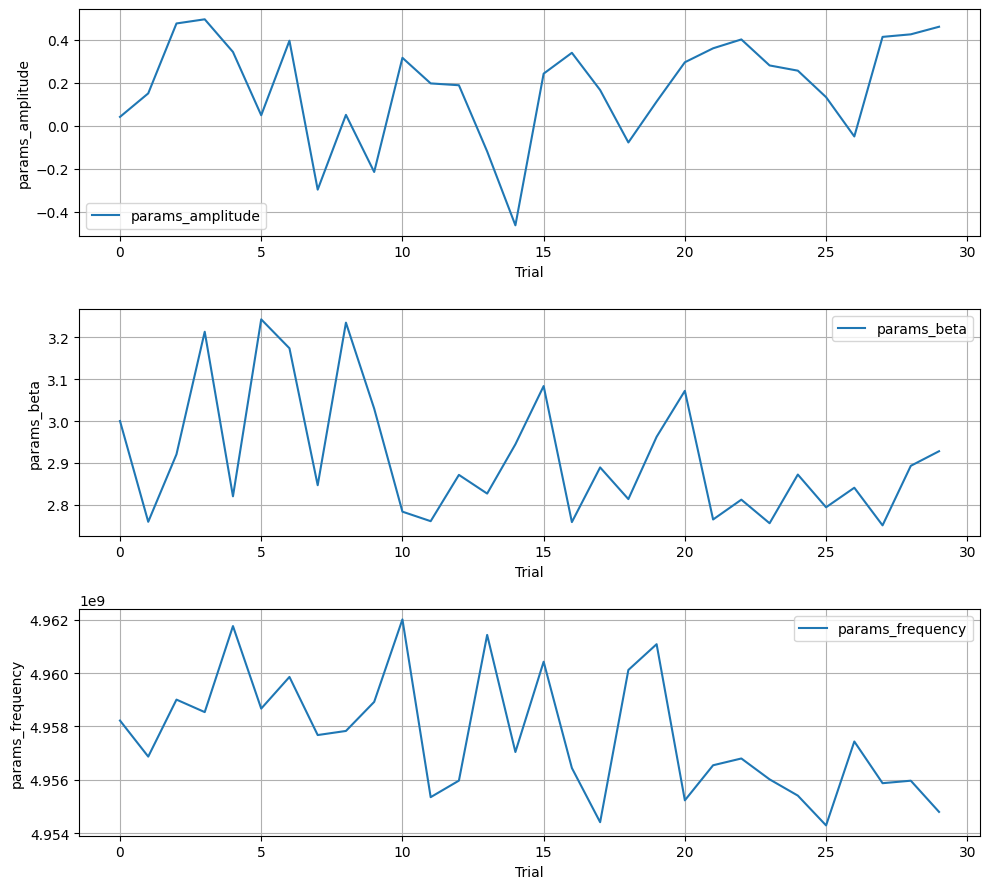

In [6]:
# Get all trials and plot parameter histories individually
trials = study.trials_dataframe()

# Separate plots for each parameter
params_columns = [col for col in trials.columns if col.startswith("params_")]

fig, axes = plt.subplots(len(params_columns), 1, figsize=(10, len(params_columns) * 3))

for i, param in enumerate(params_columns):
    ax = axes[i]
    ax.plot(trials["number"], trials[param], label=param)
    ax.set_xlabel("Trial")
    ax.set_ylabel(param)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Optimization analysis

In [7]:
df = study.trials_dataframe()

#NB: objective value is RB infidelity
objective_values = df['value'].to_numpy()
objective_error = df['user_attrs_error'].to_numpy()
iterations = df['number']

#build params dictionary
params = {par: df[par].dropna().to_numpy() for par in params_columns}
print(params)

{'params_amplitude': array([ 0.04110445,  0.15057528,  0.47609399,  0.49543445,  0.34337804,
        0.04874249,  0.39577822, -0.29762301,  0.05051677, -0.21539447,
        0.31612702,  0.19696682,  0.18840943, -0.11972554, -0.46370811,
        0.24247511,  0.33941981,  0.16612008, -0.07794616,  0.11236364,
        0.2953953 ,  0.36041742,  0.40169359,  0.28059395,  0.25631866,
        0.13291677, -0.05004221,  0.41357455,  0.42546226,  0.46076068]), 'params_beta': array([3.        , 2.75866782, 2.92020058, 3.21374688, 2.81970218,
       3.2433834 , 3.17413349, 2.84620893, 3.23551199, 3.02967347,
       2.78292261, 2.76012966, 2.87099344, 2.82623276, 2.94424549,
       3.08366663, 2.75795976, 2.88890972, 2.81301053, 2.96215673,
       3.07227207, 2.76420982, 2.81165714, 2.75519757, 2.87177621,
       2.7934581 , 2.84023391, 2.75012158, 2.89268889, 2.92767173]), 'params_frequency': array([4.95822267e+09, 4.95687060e+09, 4.95900748e+09, 4.95853900e+09,
       4.96176473e+09, 4.95867067e+

/tmp/ipykernel_53226/806558833.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



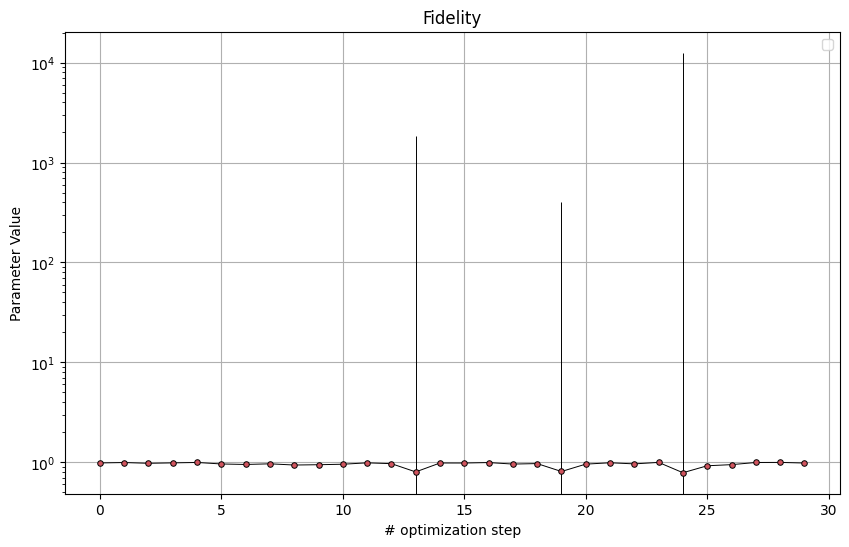

In [8]:
plt.figure(figsize=(10, 6))
plt.errorbar(iterations, 1-objective_values, yerr=objective_error, fmt = 'o', markersize=4, color='black', linestyle='-',
         markerfacecolor=RED, markeredgewidth=0.7, linewidth=0.7, alpha=1)
plt.xlabel('# optimization step')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.title(f'Fidelity')
plt.legend()
plt.grid()
plt.show()

In [9]:
for i in range(len(objective_values)):
    if 1-objective_values[i] + objective_error[i] > 1:
        print(i)

13
19
24


/tmp/ipykernel_37722/3497117488.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



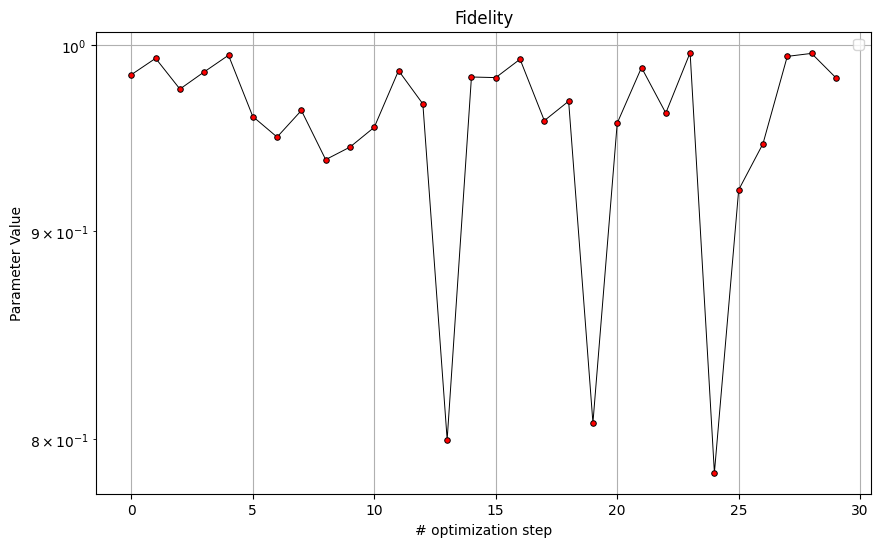

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(iterations, 1 - objective_values, 'o-', markersize=4, color='black', 
         markerfacecolor='red', markeredgewidth=0.7, linewidth=0.7, alpha=1)
plt.xlabel('# optimization step')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.title(f'Fidelity')
plt.legend()
plt.grid()
plt.show()

In [19]:
best_trial = study.best_trial

print("Best trial:")
print(f"  Trial number: {best_trial.number}")
print(f"  Value (Objective): {best_trial.value}")
print("  Parameters:")

for param_name, param_value in best_trial.params.items():
    print(f"    {param_name}: {param_value}")

print(f"fidelity: {1-best_trial.value}")

Best trial:
  Trial number: 23
  Value (Objective): 0.004166867618496717
  Parameters:
    amplitude: 0.28059394640387375
    frequency: 4956017431.752749
    beta: 2.755197569735461
fidelity: 0.9958331323815033


## Inspectring database structure

In [7]:
print("Columns in Optuna study trials DataFrame")
print(df.info())
print(df.head())

Columns in Optuna study trials DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   number                     30 non-null     int64          
 1   value                      30 non-null     float64        
 2   datetime_start             30 non-null     datetime64[ns] 
 3   datetime_complete          30 non-null     datetime64[ns] 
 4   duration                   30 non-null     timedelta64[ns]
 5   params_amplitude           30 non-null     float64        
 6   params_beta                30 non-null     float64        
 7   params_frequency           30 non-null     float64        
 8   user_attrs_error           30 non-null     float64        
 9   system_attrs_fixed_params  1 non-null      object         
 10  state                      30 non-null     object         
dtypes: datetime64[ns](2